In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Florence-2-Birds'

In [ ]:
!ls /content/drive/MyDrive/Florence-2-Birds

images	metadata_10k.csv


In [ ]:
import pandas as pd

metadata = pd.read_csv(path + '/metadata_10k.csv')
metadata.head(5)

,fileNameAsDelivered,scientificName
0,Black_Footed_Albatross_0046_18.jpg,Phoebastria nigripes
1,Black_Footed_Albatross_0009_34.jpg,Phoebastria nigripes
2,Black_Footed_Albatross_0002_55.jpg,Phoebastria nigripes
3,Black_Footed_Albatross_0074_59.jpg,Phoebastria nigripes
4,Black_Footed_Albatross_0014_89.jpg,Phoebastria nigripes


In [ ]:
unique_scientificName = metadata['scientificName'].nunique()
print("Unique Scientific Name: ", unique_scientificName)

Unique Scientific Name:  188


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   fileNameAsDelivered  11092 non-null  object
 1   scientificName       11092 non-null  object
dtypes: object(2)
memory usage: 173.4+ KB


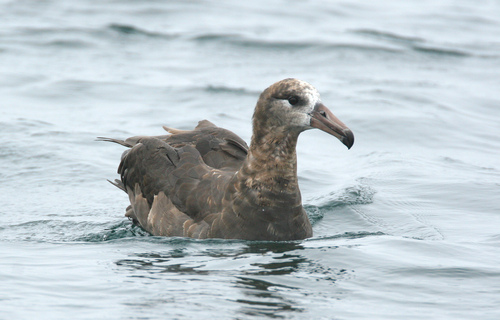

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = path + '/images/Black_Footed_Albatross_0081_426.jpg'
img = Image.open(img_path)

img

# Let's apply Florence-2 for object detection

In [ ]:
!pip install timm flash_attn einops;

In [ ]:
!pip install timm flash_attn

In [ ]:
# Reference: https://github.com/AssemblyAI-Community/florence-2/blob/master/florence-2-how-to-use.ipynb

import copy

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests


%matplotlib inline

# Load Florence-2 and processor
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [ ]:
print(model)

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

In [ ]:
def run_example(task_prompt, image):
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

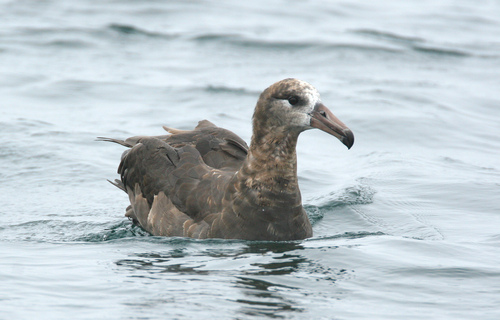

In [ ]:
img_path = path + '/images/Black_Footed_Albatross_0081_426.jpg'
img = Image.open(img_path)

img

### To process the location tokens and render them on the image, the following method will be called to plot bounding boxes.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bounding_box(image, data):

    fig, ax = plt.subplots()
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()


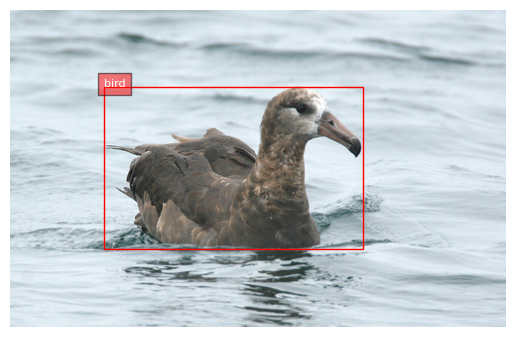

In [ ]:
task_prompt = '<OD>'
od_result = run_example(task_prompt, img)
plot_bbox(img, od_result['<OD>'])

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms.functional import to_tensor

In [ ]:
# Load the Mask R-CNN model
instance_segmentation_model = maskrcnn_resnet50_fpn(pretrained=True).eval().cuda()

def run_instance_segmentation(image):
    # Transform image to tensor
    img_tensor = to_tensor(image).unsqueeze(0).cuda()

    with torch.no_grad():
        predictions = instance_segmentation_model(img_tensor)

    return predictions

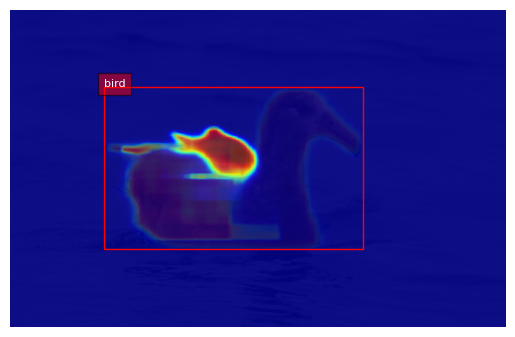

In [ ]:
def plot_instance_segmentation(image, od_data, seg_data):
    fig, ax = plt.subplots()

    ax.imshow(image)

    for bbox, label in zip(od_data['<OD>']['bboxes'], od_data['<OD>']['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Plot instance segmentation masks from Mask R-CNN
    for mask in seg_data[0]['masks']:
        mask = mask.squeeze().cpu().numpy()
        ax.imshow(mask, cmap='jet', alpha=0.5)

    ax.axis('off')
    plt.show()


plot_instance_segmentation(img, od_result, instance_segmentation_results)

In [ ]:
# Load the Mask R-CNN model
instance_segmentation_model = maskrcnn_resnet50_fpn(pretrained=True).eval().cuda()

def run_instance_segmentation(image):
    img_tensor = to_tensor(image).unsqueeze(0).cuda()

    # Run Mask R-CNN
    with torch.no_grad():
        predictions = instance_segmentation_model(img_tensor)

    return predictions

segmentation_results = run_instance_segmentation(img)

In [ ]:
print(segmentation_results)

[{'boxes': tensor([[113.2069,  82.1128, 351.6930, 240.7604],
        [ 98.4093, 124.3339, 271.0064, 231.3333],
        [112.9998, 121.1546, 247.5073, 171.1651],
        [152.7843, 117.7751, 254.2779, 191.8779]], device='cuda:0'), 'labels': tensor([16, 16, 16, 16], device='cuda:0'), 'scores': tensor([0.9922, 0.7787, 0.6886, 0.1738], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0.

In [ ]:
import numpy as np
import cv2

def extract_segment_traits(image, segmentation_results):
    img_np = np.array(image)
    traits = []

    for mask, bbox, label in zip(segmentation_results[0]['masks'], segmentation_results[0]['boxes'], segmentation_results[0]['labels']):
        mask = mask.squeeze().cpu().numpy()  # Convert mask to numpy array
        label = label.item()  # Get the object class label

        traits_for_instance = {}

        area = np.sum(mask)
        traits_for_instance['area'] = area


        masked_image = img_np * mask[:, :, None]
        avg_color = np.mean(masked_image[mask != 0], axis=0)
        traits_for_instance['average_color'] = avg_color.tolist()

        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        traits_for_instance['num_contours'] = len(contours)

        traits_for_instance['label'] = label
        traits_for_instance['bbox'] = bbox.cpu().numpy().tolist()

        traits.append(traits_for_instance)

    return traits

In [ ]:
segment_traits = extract_segment_traits(img, segmentation_results)
for trait in segment_traits:
    print(trait)

{'area': 19931.662, 'average_color': [52.067623138427734, 50.3404426574707, 47.03417205810547], 'num_contours': 0, 'label': 16, 'bbox': [113.20687103271484, 82.11284637451172, 351.6929626464844, 240.7604217529297]}
{'area': 8497.977, 'average_color': [43.992923736572266, 42.351810455322266, 39.470314025878906], 'num_contours': 0, 'label': 16, 'bbox': [98.40931701660156, 124.3338851928711, 271.0064392089844, 231.3333282470703]}
{'area': 2472.6074, 'average_color': [38.7746467590332, 37.659305572509766, 36.01972579956055], 'num_contours': 0, 'label': 16, 'bbox': [112.9997787475586, 121.15461730957031, 247.50732421875, 171.1650848388672]}
{'area': 2440.218, 'average_color': [33.2170524597168, 32.04948806762695, 30.439083099365234], 'num_contours': 0, 'label': 16, 'bbox': [152.7843475341797, 117.77510833740234, 254.27793884277344, 191.87794494628906]}


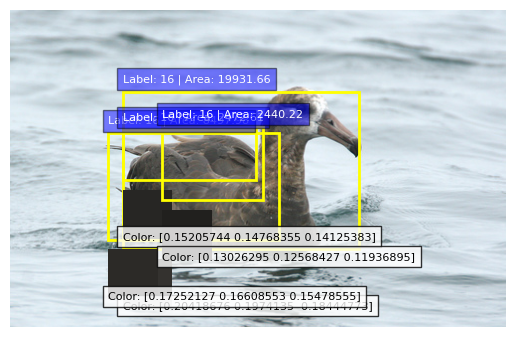

In [ ]:
def visualize_traits(image, segment_traits):
    fig, ax = plt.subplots()
    img_np = np.array(image)
    ax.imshow(img_np)

    for trait in segment_traits:
        x1, y1, x2, y2 = trait['bbox']
        width, height = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)

        # Visualize the average color as a small patch
        avg_color = np.array(trait['average_color']) / 255.0
        color_patch = patches.Rectangle((x1, y2 + 10), 50, 50, linewidth=2, edgecolor='none', facecolor=avg_color)
        ax.add_patch(color_patch)

        label = trait['label']
        area = trait['area']
        plt.text(x1, y1 - 10, f'Label: {label} | Area: {area:.2f}', color='white', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))

        plt.text(x1, y2 + 60, f'Color: {avg_color}', color='black', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    ax.axis('off')
    plt.show()

visualize_traits(img, segment_traits)
